# Stanと ~R~ Pythonでベイズ統計モデリング
## Stanの基本的な文法


data{<br>データの宣言<br>}<br>parameters{<br>サンプリングしたいパラメータ$\theta$<br>}
<br><br>model{<br>尤度$p(Y|\theta)$<br>事前分布$p(\theta)$<br>}

### memo

- stanでは、値が決まってなく、確率変数とみなせるものは全てparametersにいれる。
- 渡辺ベイズによると、データが確率変数の観測値としてみなせるために、事後分布なんかも確率変数と言うこと。
- 確率モデル、事前分布も自分で定義するもので事後分布も定義してるとみなす。

- 著者によるとモデリングのコツは、
     1. 最初にモデル部分を記述する
     2. それから、dataにデータの変数を記述、残りをparametersに記述

の流れで無理に初めから埋めていかないことがコツらしい。

##  トイデータで試してみる

$$\begin{eqnarray}Y &\sim& Nonmal(\mu, 1) \\ \mu &\sim& Normal(0, 100)\end{eqnarray}$$

のモデルで、StanでMCMC(Nuts)を使ってパラメータの事後分布を実現させる。

Stanの開発者は、Stringでの記述よりは.Stanファイルに記述することを勧めてる

ここではファイルを分けると行き来がめんどくさいのでStringでモデルを記述する。


In [60]:
import pystan
import numpy as np

In [61]:
model = """

data{
    int<lower=0> N; // データの数
    real Y[N];
}

parameters{
    real mu;
}

model{
    for (n in 1:N) {
        Y[n] ~ normal(mu, 1); // normal(mean, std)に注意
    }
    
    mu ~ normal(0, 100);
}

"""

In [62]:
# complie モデルのコンパイル。時間がかかる。
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52b68c77f1118b7ac65d57587cc89f92 NOW.


In [63]:
data = {"N":8, "Y":[15, 10, 16, 11, 9, 11, 10, 18]}
fit = sm.sampling(
        data=data, iter=1000, chains=4
)

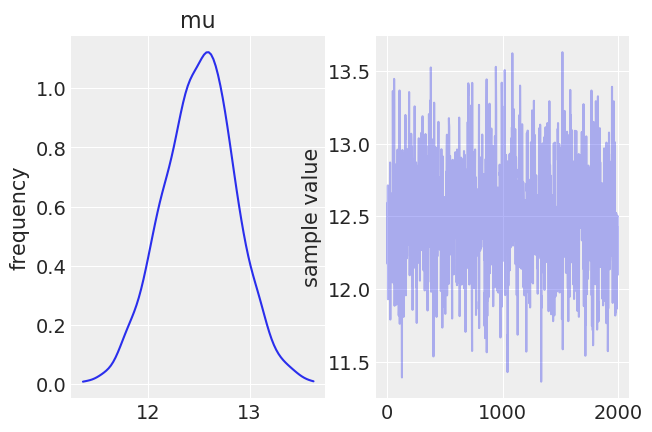

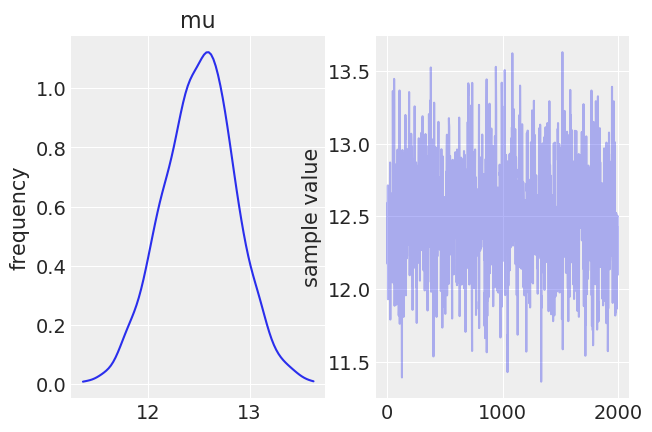

In [64]:
fit.plot()

In [65]:
np.mean(data["Y"])

12.5

## arvizで予測分布まで

In [66]:
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])


In [67]:
schools_model = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}


sm = pystan.StanModel(model_code=schools_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0eada194ad938e30ed47926216f98ca NOW.


In [75]:
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

- パラメータの事後分布の可視化にはpystanではarvizを使う。

今回MCMCサンプリングしたあとの結果をfitに格納しているので```fit.plot()```もできるがwarningがでて

```arviz```を使うよう勧められる。

インストールはanacondaを使っていれば```conda install -c conda-forge arviz```

使い方詳しくは[公式](https://arviz-devs.github.io/arviz/notebooks/Introduction.html)

In [76]:
import arviz as az

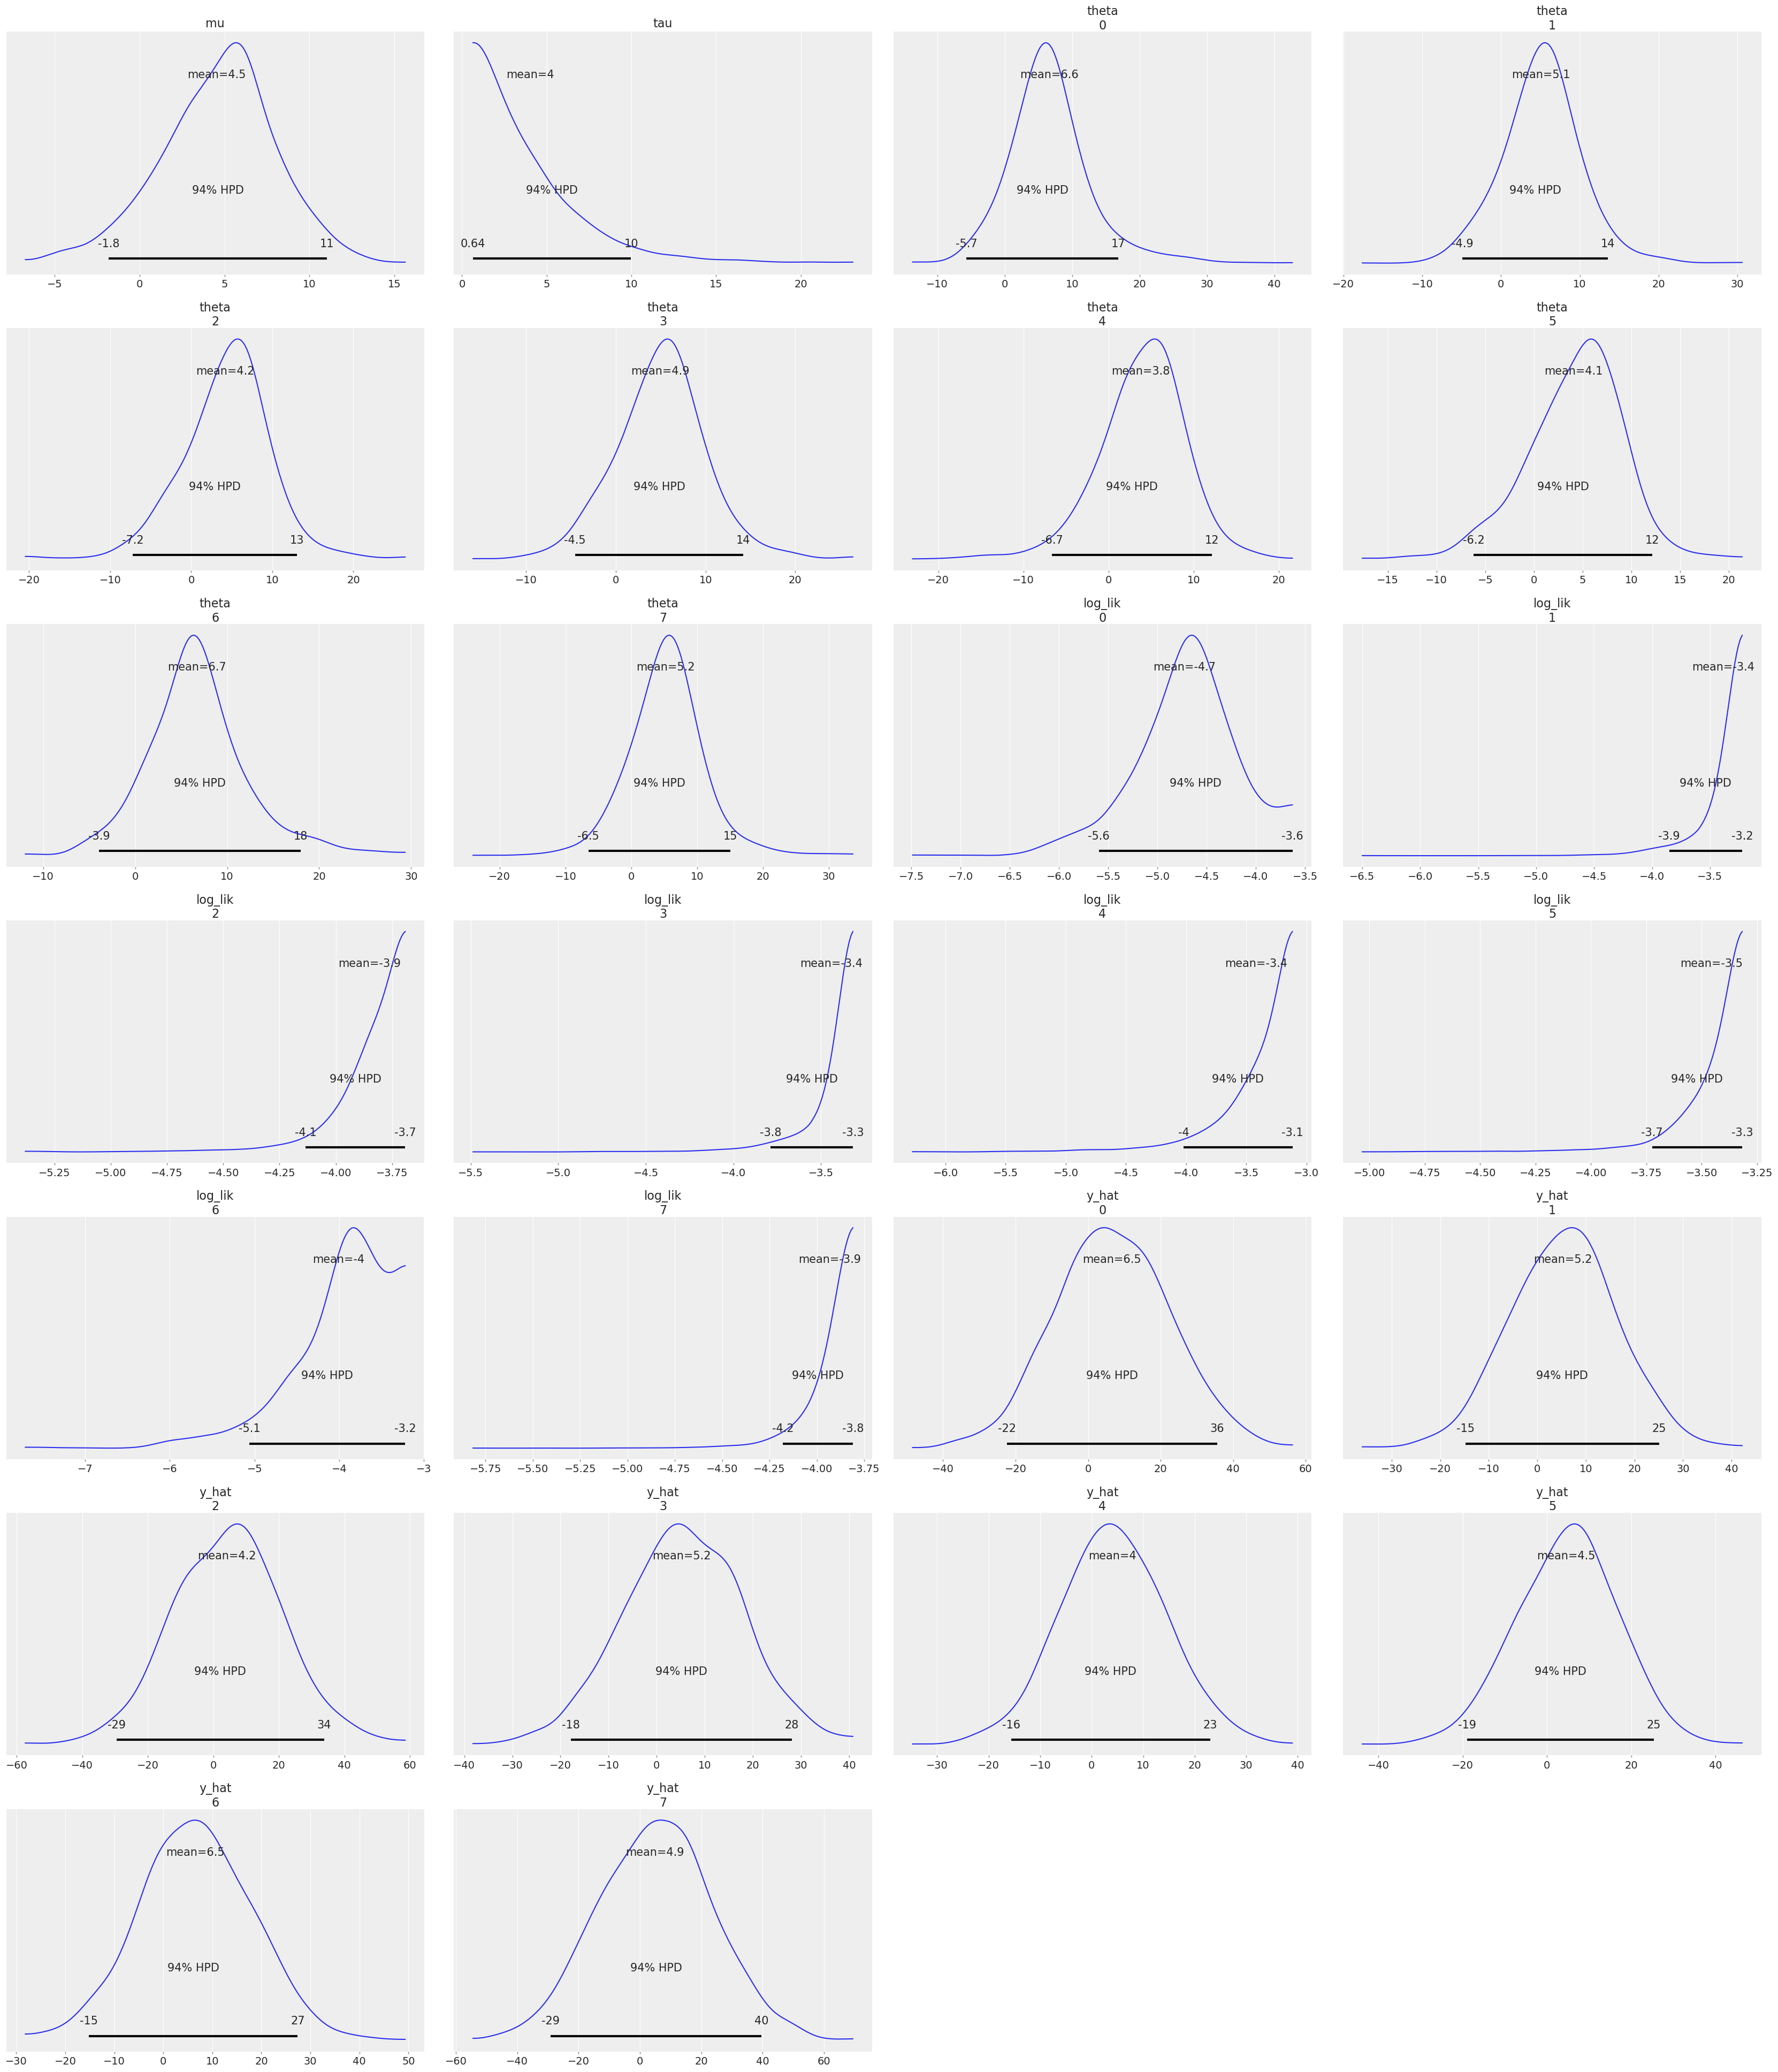

In [77]:
az.style.use("arviz-darkgrid")
az.plot_posterior(fit);

In [78]:
print(fit)

Inference for Stan model: anon_model_b0eada194ad938e30ed47926216f98ca.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu           4.54    0.25   3.37  -2.68   2.47   4.85   6.67  10.84    184   1.02
tau          4.02    0.28   3.29   0.69   1.64   3.04   5.31  12.96    133   1.02
theta[1]     6.58    0.26   5.96  -4.02   3.13   6.16   9.16   21.7    512   1.01
theta[2]     5.06    0.23   4.88  -4.76   2.15   5.14   7.82  14.97    449   1.01
theta[3]      4.2    0.25   5.48  -7.05   1.13    4.7   7.28  14.59    467   1.01
theta[4]     4.92    0.23   5.04  -4.79   1.89   5.22   7.83  15.28    493   1.01
theta[5]     3.79    0.29   5.11  -7.69   1.07   4.29   6.89  13.03    319   1.01
theta[6]     4.09     0.3    4.9  -6.42   1.27    4.7   7.41  12.81    260   1.02
theta[7]     6.68    0.29   5.48  -3.79   3.51   6.27   9.29  20.06    363 

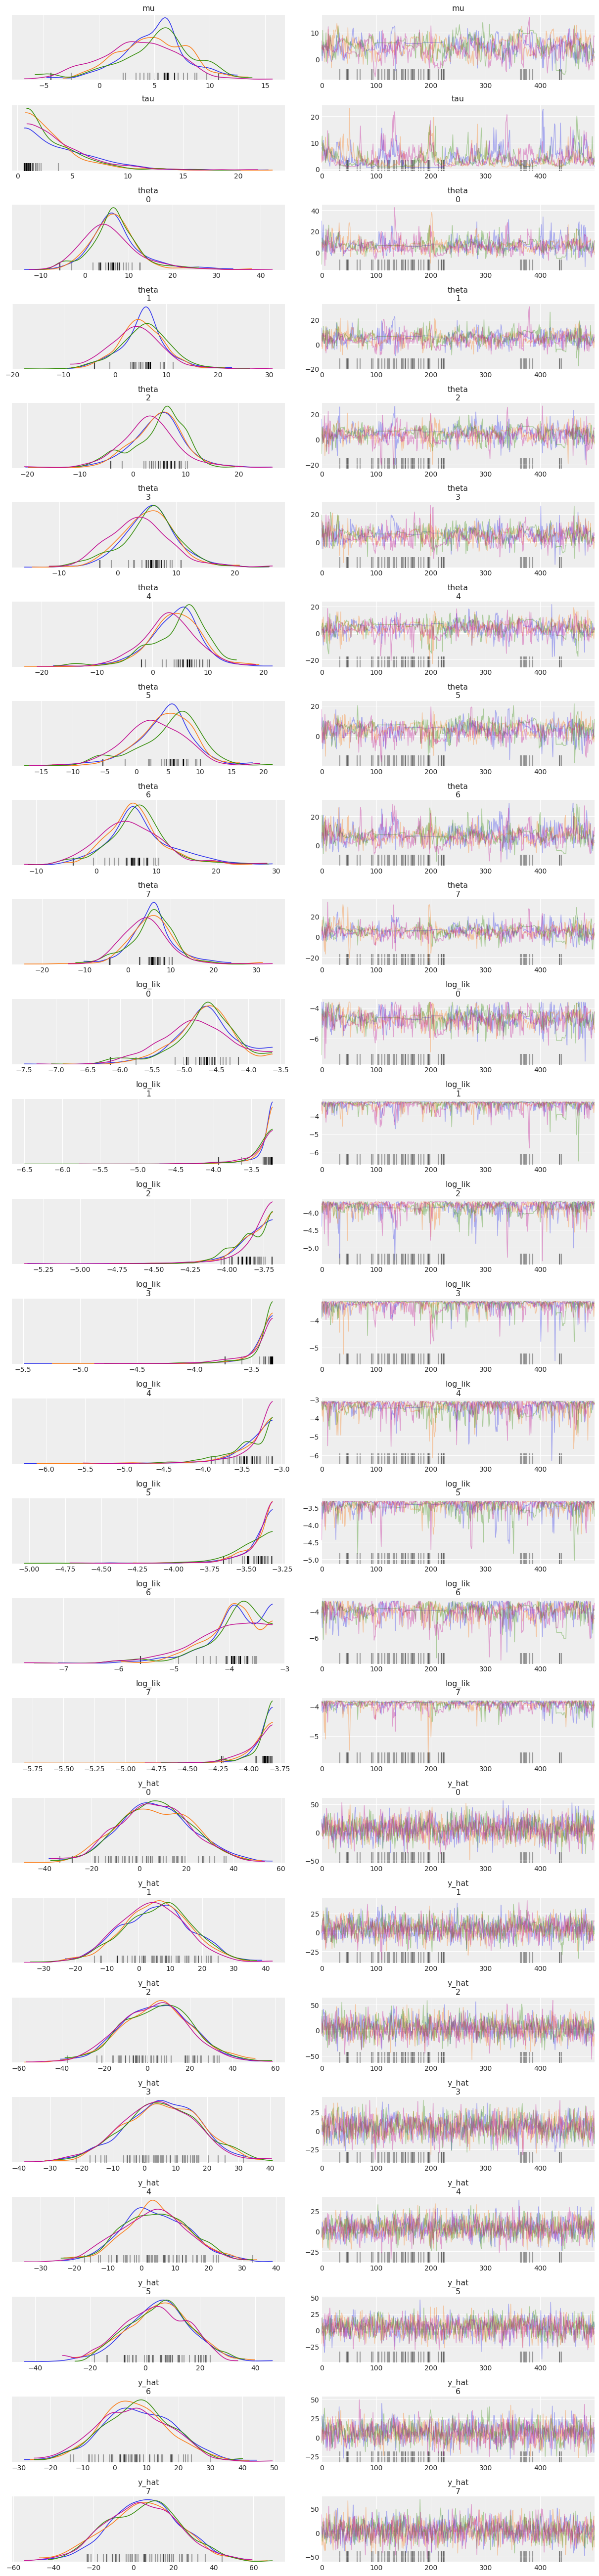

In [79]:
az.plot_trace(fit);

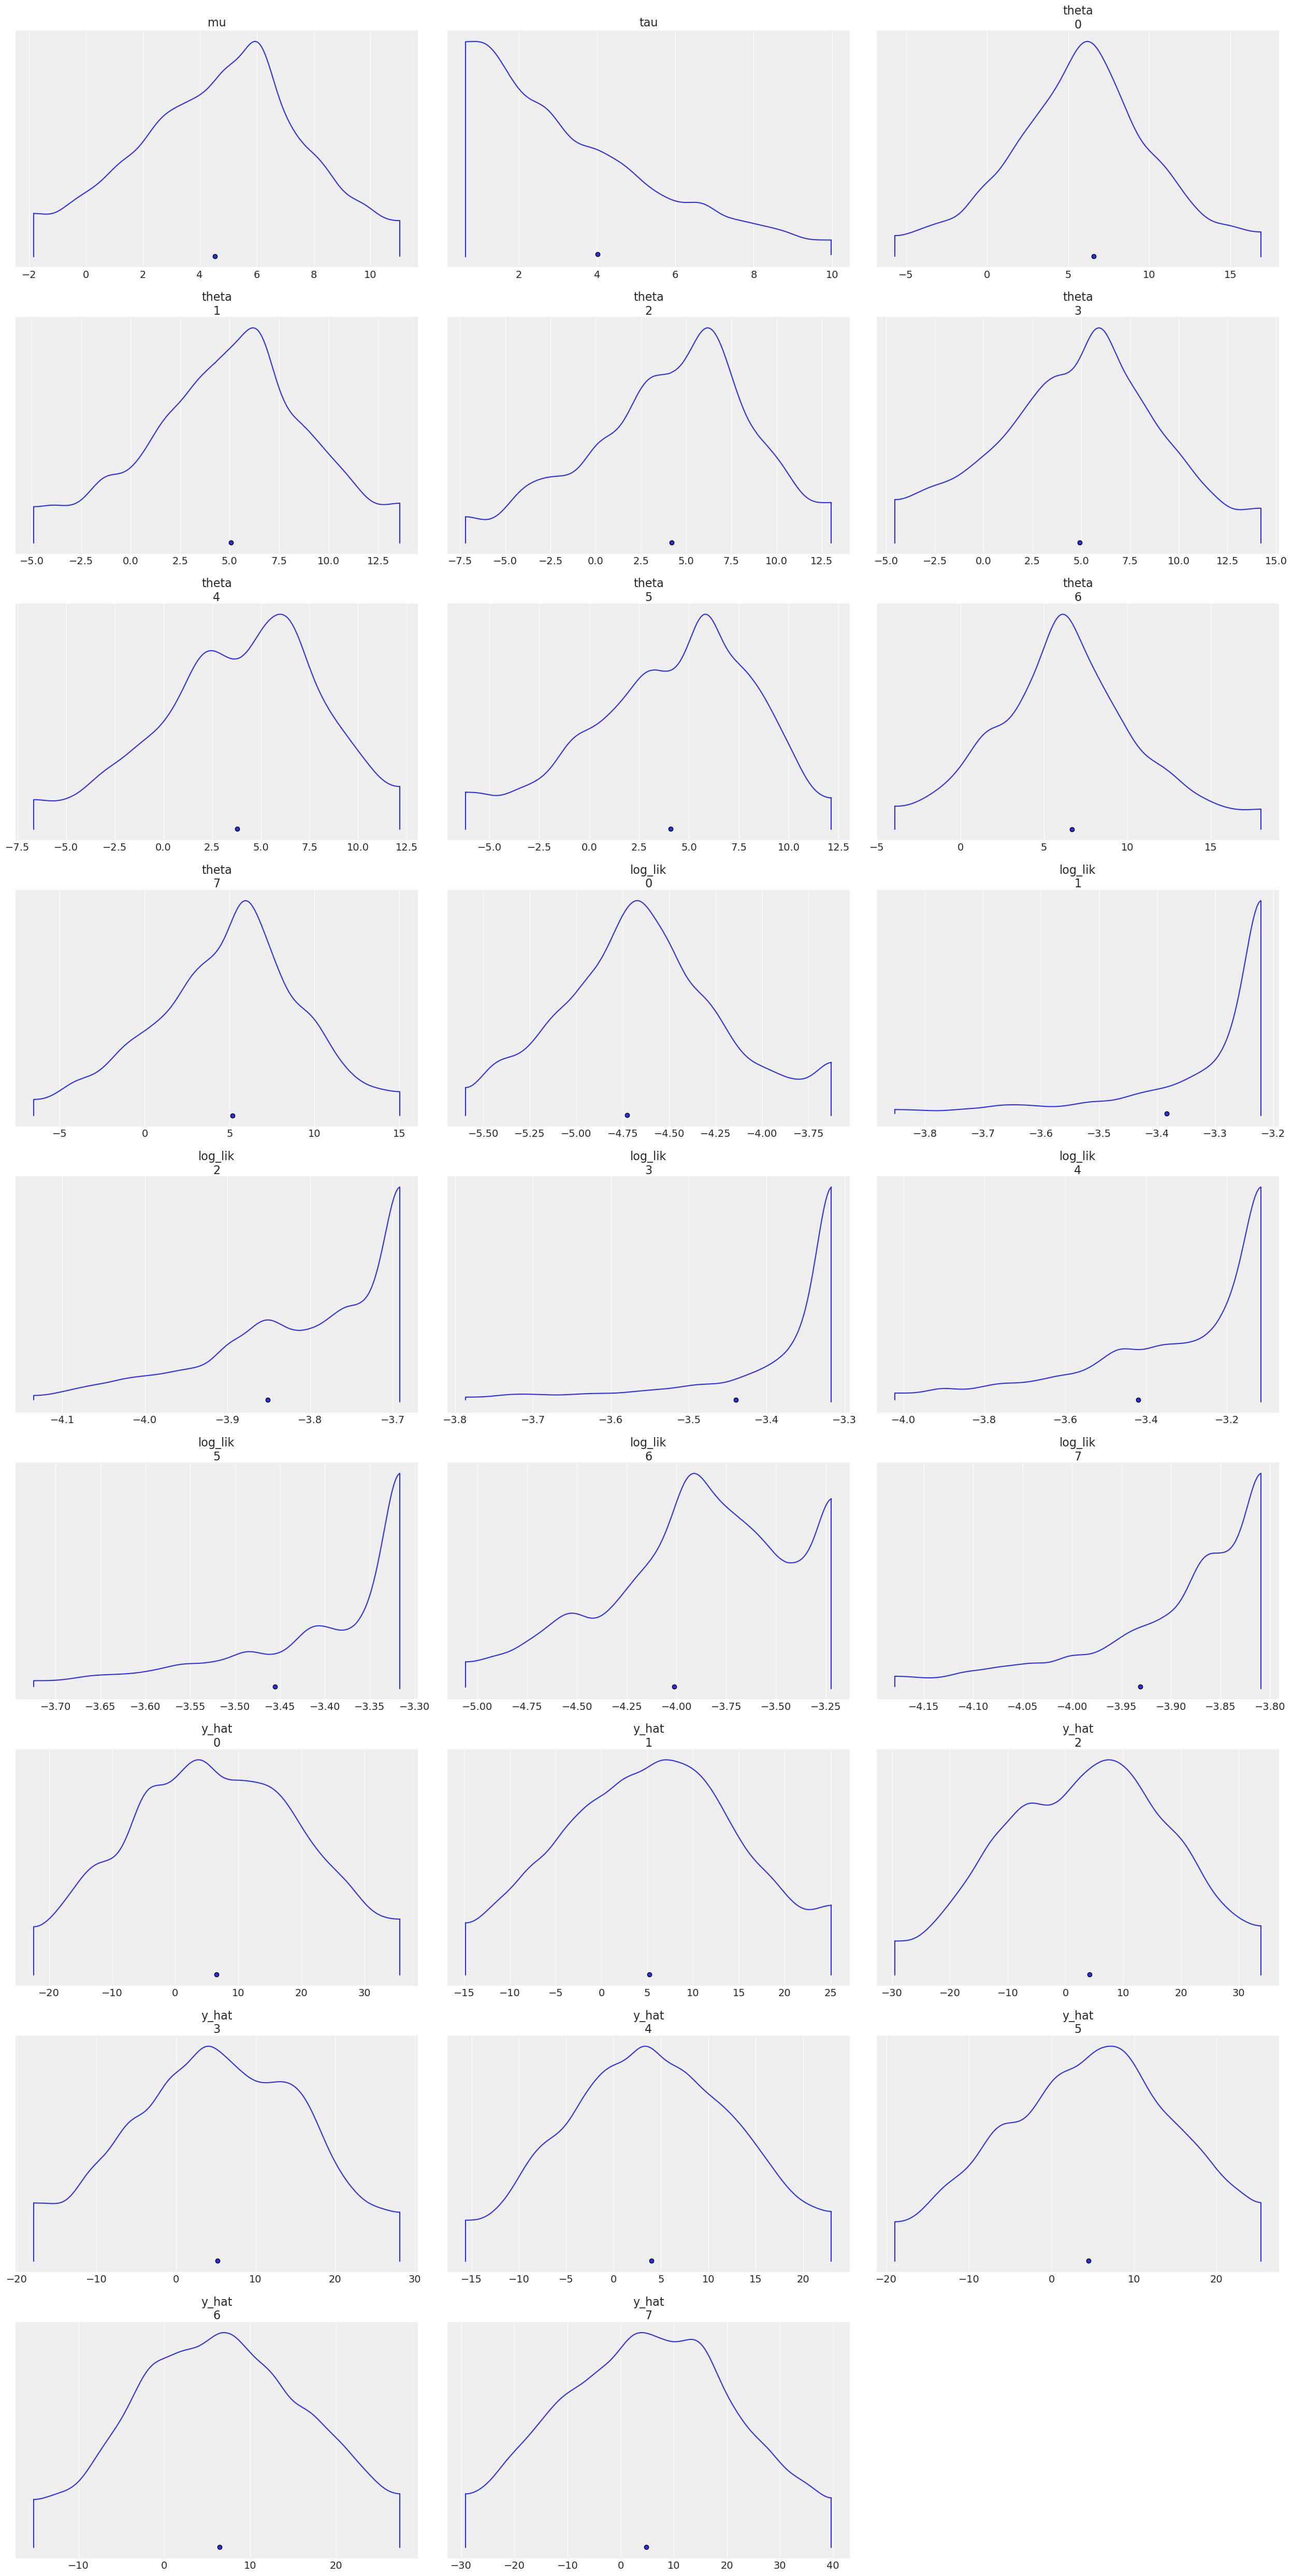

In [80]:
az.plot_density(fit);

今まではパラメータの事後分布$p(w|X) \propto p(X|w)p(w)$をMCMCサンプリングで近似的に求めたので、

そのパラメータの事後分布で確率モデルを平均した予測分布$p(x^*|X)=\int p(x*|w)p(w|X)$を求める。

ベイズ推定による統計モデリングでは、この予測分布とサンプルを発生している真の確率分布との誤差（汎化誤差）を小さくすることを目指す。

詳しくは、[ベイズ統計の理論と方法](http://watanabe-www.math.dis.titech.ac.jp/users/swatanab/bayes-theory-method.html)や[著者HPの講義資料やQA](http://watanabe-www.math.dis.titech.ac.jp/users/swatanab/index-j.html)を参照。

- [arviz.from_pystan document](https://arviz-devs.github.io/arviz/generated/arviz.from_pystan.html)

    - ```cords``` : インデックスとして使われてる値

In [108]:
data = az.from_pystan(
    posterior=fit,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'y': 'log_lik'},
    coords={'school': schools},
    dims={
        'theta': ['school'],
        'y': ['school'],
        'log_lik': ['school'],
        'y_hat': ['school'],
        'theta_tilde': ['school']
    }
)
data

Inference data with groups:
	> posterior
	> sample_stats
	> log_likelihood
	> posterior_predictive
	> observed_data

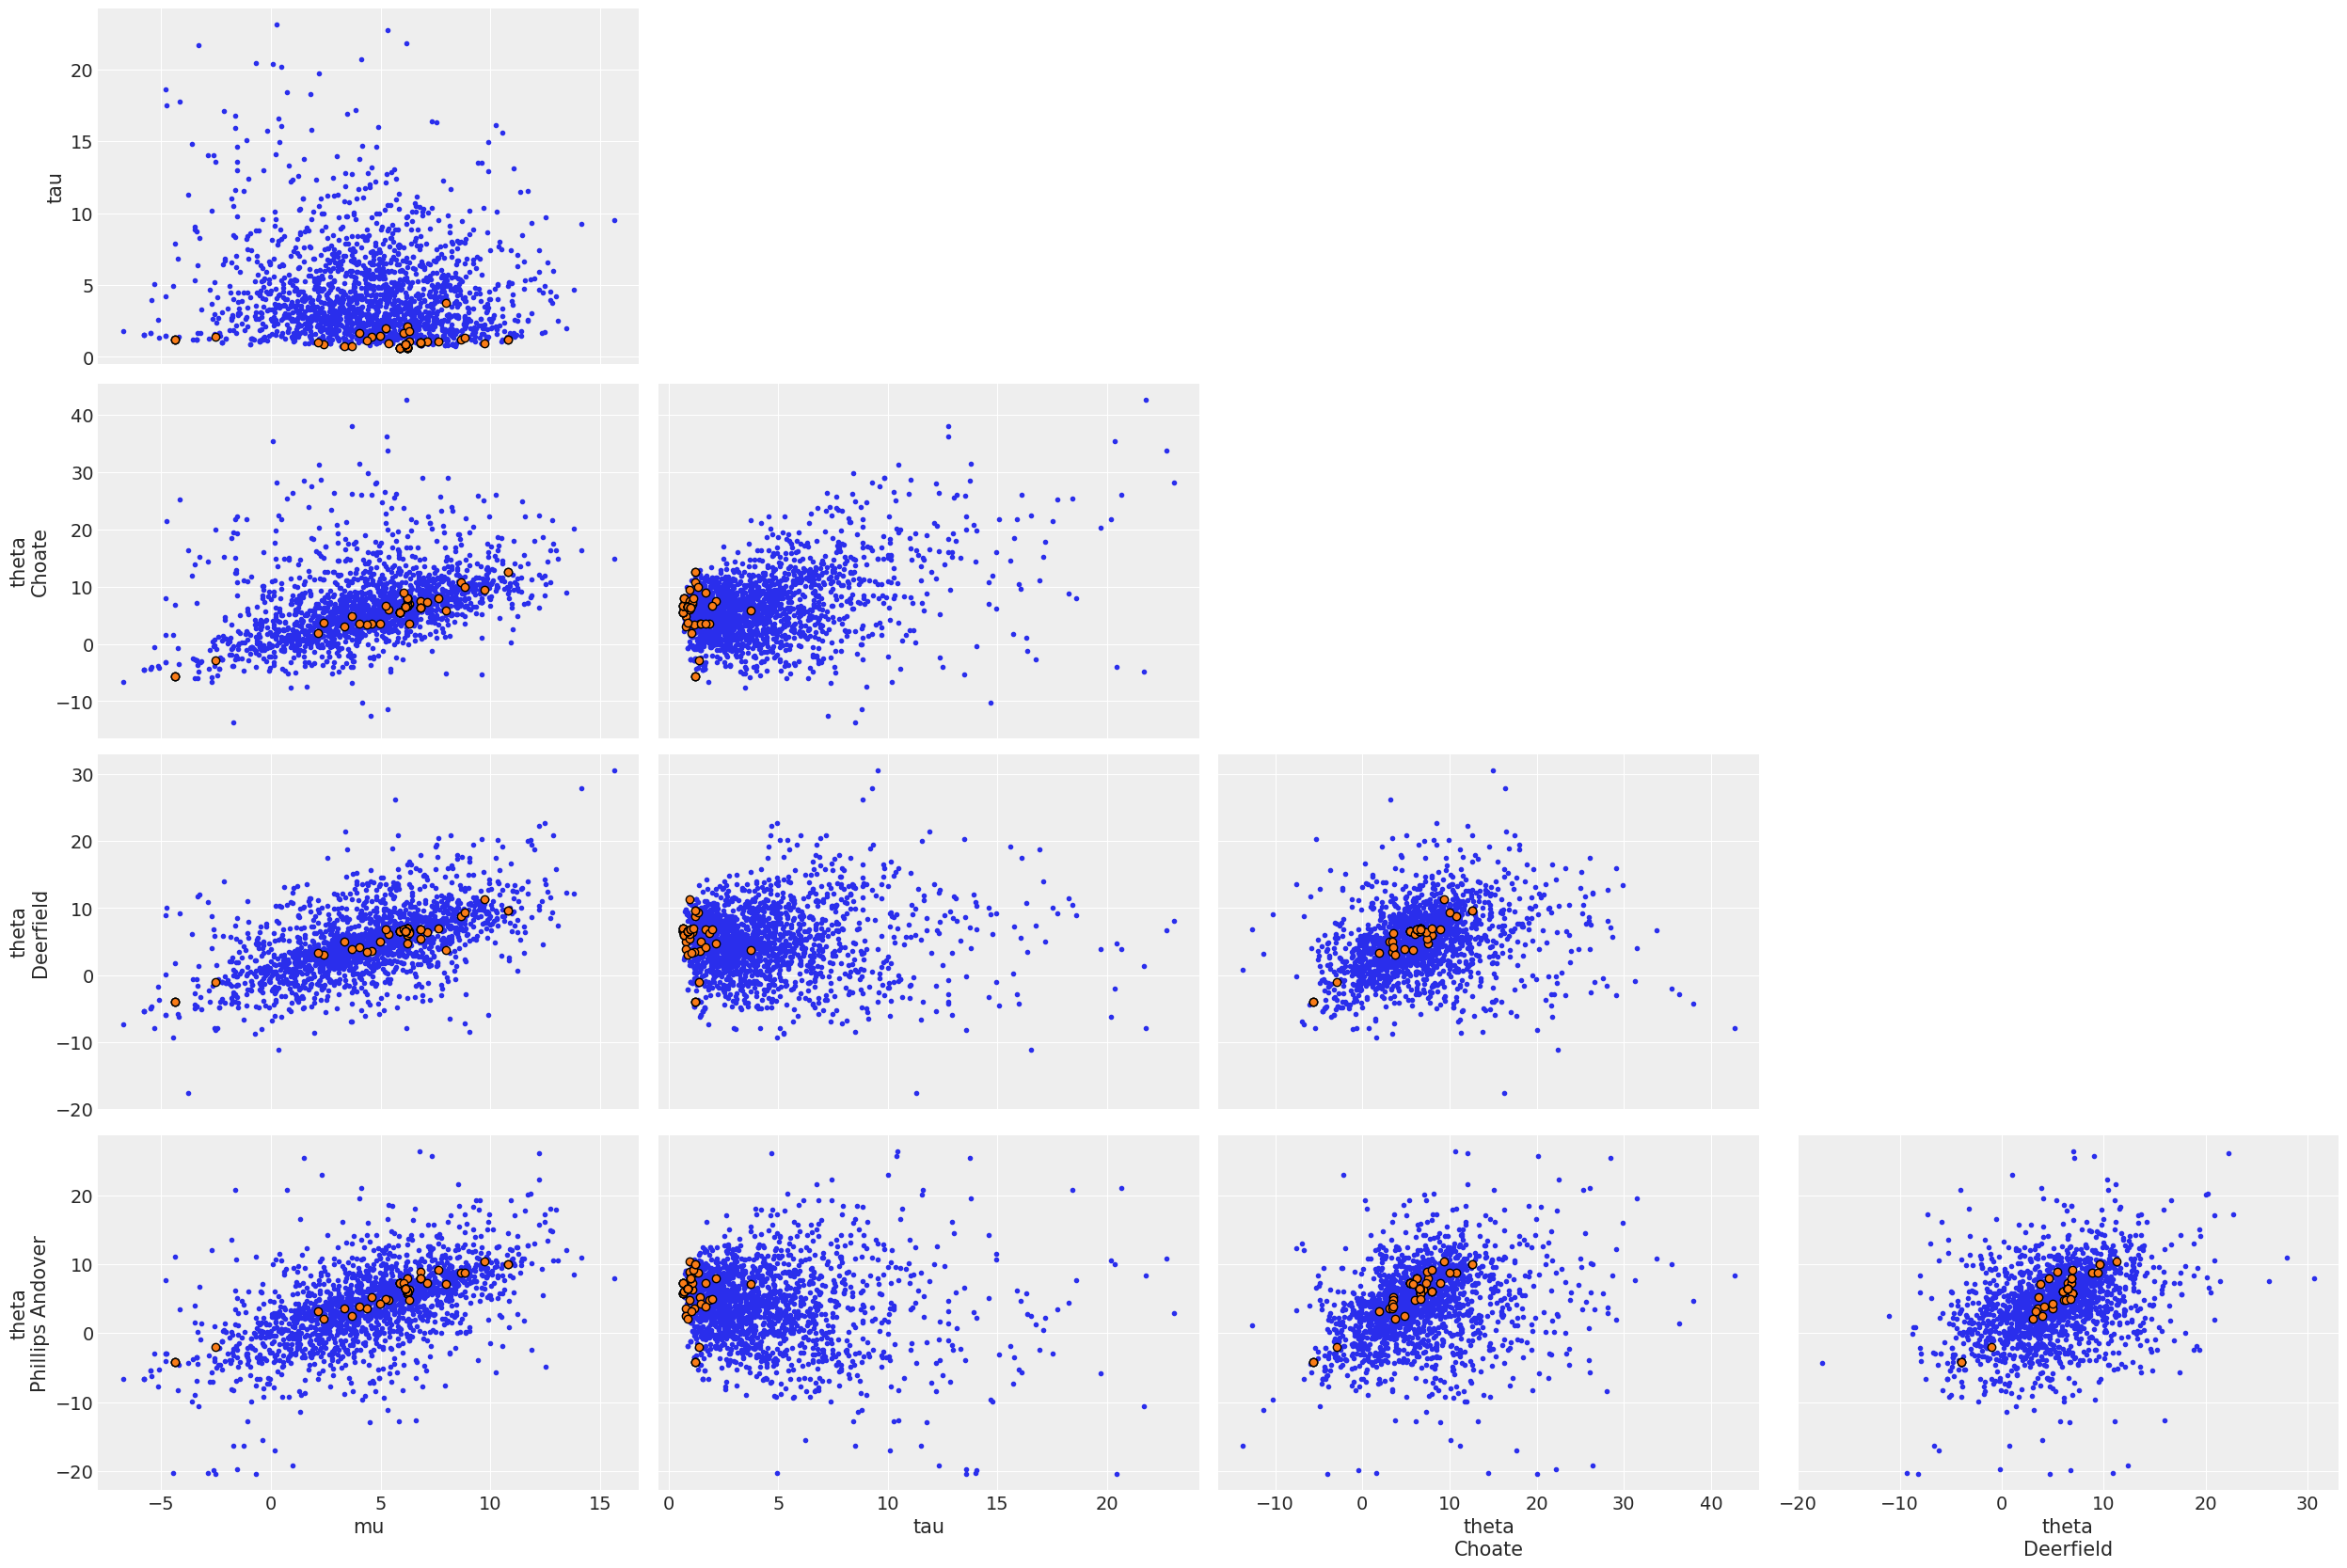

In [85]:
az.plot_pair(inference_dist, coords={'school': ['Choate', 'Deerfield', 'Phillips Andover']}, divergences=True);

In [94]:
data = az.convert_to_inference_data(fit)
data

Inference data with groups:
	> posterior
	> sample_stats

In [95]:
data.posterior

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 500, log_lik_dim_0: 8, theta_dim_0: 8, y_hat_dim_0: 8)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * theta_dim_0    (theta_dim_0) int64 0 1 2 3 4 5 6 7
  * log_lik_dim_0  (log_lik_dim_0) int64 0 1 2 3 4 5 6 7
  * y_hat_dim_0    (y_hat_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    mu             (chain, draw) float64 4.425 -0.6296 3.46 ... 3.296 8.811 8.51
    tau            (chain, draw) float64 8.414 7.017 9.772 ... 4.05 4.119 2.837
    theta          (chain, draw, theta_dim_0) float64 29.85 13.38 ... 12.73
    log_lik        (chain, draw, log_lik_dim_0) float64 -3.635 -3.366 ... -3.81
    y_hat          (chain, draw, y_hat_dim_0) float64 23.09 9.369 ... 9.05 5.743
Attributes:
    created_at:                 2020-03-03T14:54:56.617175
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.1.1

In [97]:
data.sample_stats

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 500)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    accept_stat  (chain, draw) float64 0.9796 0.9996 0.9918 ... 0.9428 0.9959
    stepsize     (chain, draw) float64 0.2139 0.2139 0.2139 ... 0.1992 0.1992
    treedepth    (chain, draw) int64 5 5 5 5 5 4 3 4 4 5 ... 4 3 3 3 4 3 5 3 4 3
    n_leapfrog   (chain, draw) int64 31 31 31 31 31 15 7 ... 7 31 7 47 7 23 15
    diverging    (chain, draw) bool False False False ... False False False
    energy       (chain, draw) float64 32.3 31.22 26.38 ... 18.7 22.45 18.85
    lp           (chain, draw) float64 -25.37 -23.06 -22.95 ... -15.45 -16.23
Attributes:
    created_at:                 2020-03-03T14:54:56.621722
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.1.1

In [107]:
inference_dist

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 500, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * school   (school) <U16 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 4.425 -0.6296 3.46 5.713 ... 3.296 8.811 8.51
    tau      (chain, draw) float64 8.414 7.017 9.772 10.94 ... 4.05 4.119 2.837
    theta    (chain, draw, school) float64 29.85 13.38 15.98 ... 12.37 12.73
Attributes:
    created_at:                 2020-03-03T14:36:49.936134
    arviz_version:              0.7.0
    inference_library:          pystan
    inference_library_version:  2.19.1.1